<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/basics_of_neural_network/understanding_stochastic_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Stochastic Gradient Descent

This notebook aims to provide a brief understanding of gradient descent as an algorithm in Machine Learning

## What is Gradient Descent?

Gradient descent is a method for unconstrained mathematical optimization. It is a first-order iterative algorithm for finding a local minimum of a differentiable multivariate function.

Reference: https://en.wikipedia.org/wiki/Gradient_descent

The alogrithm takes repeated steps in the opposite direction of the gradient of the function at the current point to achieve the best possible set of parameters / coefficients for a given model, data points to find the local minimum of a loss function.

To illustrate the idea, we can think of gradient descent as climbing down a hill until a local or global loss minimum is reached. In each iteration, we take a step in the opposite direction of the gradient, where the step size is determined by the value of the learning rate, as well as the slop of the gradient. Below graph visualize the paht of gradient descent for a single parameter $w$ to Loss function $L(w)$

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/basics_of_neural_network/assets/gradient_descent_illustration.png?raw=true">

Note that a simple extension of gradient descent, stochastic gradient descent, serves as the most basic algorithm used for training most deep networks today.


## Steps of Gradient Descent

0. Define the model for the problem
1. Initialize the weights.
2. Make predictions using the model with initialised weights
3. Compute the Loss
4. Compute the Gradients
5. *Step* to Update the parameters
6. Go back to the step 2, and *repeat* the process.Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/basics_of_neural_network/assets/steps_of_SGD.jpg?raw=true">

## Defining a simple scalar function

$y = w \times X + b + noise$

> Note: noise is added to the scalar function for synthetic data generation

## Generate Synthetic data using the Scalar function with noise

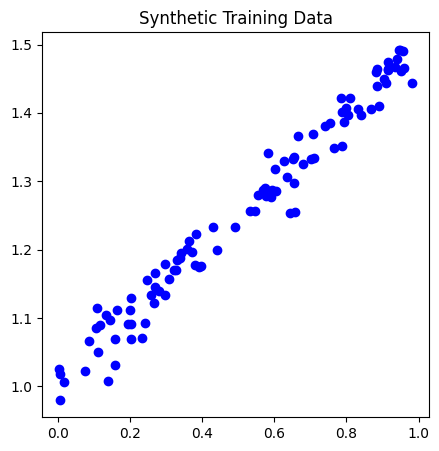

In [146]:
import torch
import matplotlib.pyplot as plt

# To ensure reproducibility
torch.manual_seed(42)

# Generating synthetic data
X = torch.rand(100) # random numbers from a uniform distribution on the interval (0, 1)
w_true, b_true = 0.5, 1
noise = torch.randn(100) * 0.03
y = w_true * X + b_true + noise

# Plot synthetic data
fig, ax = plt.subplots(1,1, sharey=True, figsize=(5,5))
ax.scatter(X, y, color="b")
ax.set_title("Synthetic Training Data");

## Step 0 - Define a model for the problem

We define a function / model `model` which is a scalar function for the regression problem (same as the syntehtic data generations without noise)

In [147]:
# Define function f to predict
def model(X, params):
    w, b = params
    return w * X + b

## Step 1 - Initialize the weights

For training a model, we need to randomly initialize the parameters / weights, in this case, we need to initialise w1, w2, and b from a scalar function model.

Tensor for training data requires the computation of its gradients, which is what the `requires_grad=True` argument is good for.


In [148]:
# Set manual seed
torch.manual_seed(42)

# generate parameters from random numbers from a normal distribution with mean 0 and variance 1
params = torch.randn(2, requires_grad=True, dtype=torch.float)
orig_params = params.clone()

# b = torch.randn(1, requires_grad=True, dtype=torch.float)
print(params) # w, b

tensor([0.3367, 0.1288], requires_grad=True)


## Step 2 - Make predictions using the model with initialised weights

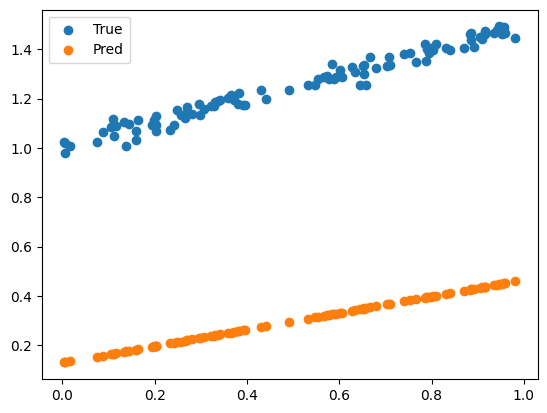

In [149]:
# Make predictions using the model with initialised random weights
y_preds = model(X, params)

# Plot out the prediction vs. true label
fig, ax = plt.subplots()
ax.scatter(X, y, label='True')
ax.scatter(X, y_preds.detach().cpu(), label='Pred')
ax.legend();

## Step 3 - Compute the Loss

For a regression problem, the loss is given by the **Mean Square Error (MSE)**

$MSE=\frac{1}{N} \sum_{i=1}^N\left(y_i-\hat{y}_i\right)^2$

 that is, the average of all squared differences labels $y$ and predictions. $w_1 \times X^2 + w_2 \times X + b$:

> Add blockquote





In [150]:
# define loss function (MSE - Mean Squared Error)
def mse(preds, targets):
  return ((preds - targets)**2).mean()

In [151]:
# Calculate Loss
loss = mse(y_preds, y)
print(f'Initial Loss: {loss.item():.3f}')

Initial Loss: 0.915


## Step 4 - Compute the Gradients

A graident is a **partial derivative** where it tells you how much a given quantity changes when there is a slight variation with respect to the **single parameter**

$
\begin{gathered}
\frac{\partial MSE}{\partial b}=\frac{\partial MSE}{\partial \hat{y}_i} \cdot \frac{\partial \hat{y}_i}{\partial b}=\frac{1}{N} \sum_{i=1}^N 2\left(y_i-b-w x_i\right) \cdot(-1)=-2 \frac{1}{N} \sum_{i=1}^N\left(y_i-\hat{y}_i\right) \\
\frac{\partial M S E}{\partial w}=\frac{\partial M S E}{\partial \hat{y}_i} \cdot \frac{\partial \hat{y}_i}{\partial }=\frac{1}{N} \sum_{i=1}^N 2\left(y_i-b-w x_i\right) \cdot\left(-x_i\right)=-2 \frac{1}{N} \sum_{i=1}^N x_i\left(y_i-\hat{y}_i\right)
\end{gathered}
$

**Autograd** is PyTorch's automatic differentiaion package. With **Autograd**, we can compute the partial derivatives of the **loss** w.r.t. our parameters by invoking `backward()` method from the corresponding Python variable -> `loss.backward()`

`grad` attribute can be used to inspect the actual values of the gradients w.r.t. the parameter, e.g. `w.grad`

Note that the gradients are accumulated everytime `backward()` is called, we need to zero the grade by setting `parameter.grad = None`



In [152]:
# Manual computation of gradients
b_grad_manual = -2 * (y_preds - y).mean()
w_grad_manual = -2 * (X * (y_preds - y)).mean()
print(f'Manual Computation: Gradient of b: {b_grad_manual.item():.3f} | Gradient of w: {w_grad_manual.item():.3f}')

Manual Computation: Gradient of b: 1.910 | Gradient of w: 1.011


In [153]:
# computation using autograd
loss.backward()
w_grad_auto, b_grad_auto = params.grad
print(f'Autograd Computation: Gradient of b: {b_grad_auto.item():.3f} | Gradient of w: {w_grad_auto.item():.3f}')

Autograd Computation: Gradient of b: -1.910 | Gradient of w: -1.011


## Step 5 - `step()` to Update the parameters

Use the gradients to update hte parameters, we reverse the sign for the gradient for hte update to minimize the `loss` the learning rate $\eta$ is a multiplicative factor that need to be applied to the gradient for the parameter update.

$\begin{aligned} & w=w-\eta \frac{\partial MSE}{\partial w} \\ & b=b-\eta \frac{\partial MSE}{\partial b}\end{aligned}$

In [154]:
# Step for Gradient descent
lr = 0.1
params.data -= lr * params.grad
params.grad = None

Old loss: 0.9149365425109863
New loss: 0.5077545642852783


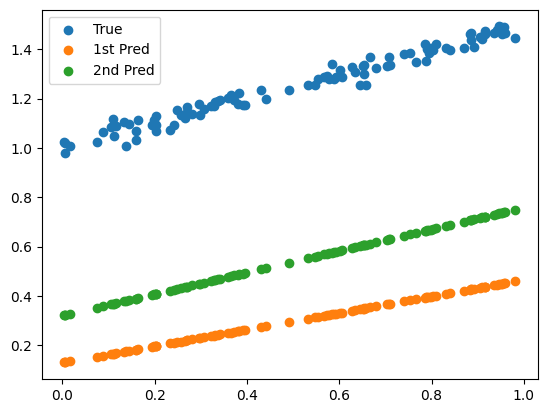

In [155]:
# Make new prediction
y_preds_orig = y_preds.clone()
y_preds = model(X, params)
print(f'Old loss: {mse(y_preds_orig, y)}')
print(f'New loss: {mse(y_preds, y)}')

# Plot the result
fig, ax = plt.subplots()
ax.scatter(X, y, label='True')
ax.scatter(X, y_preds_orig.detach().cpu(), label='1st Pred')
ax.scatter(X, y_preds.detach().cpu(), label='2nd Pred')
ax.legend();

## Step 6 - Go back to the step 2, and *repeat* the process.

Using the updated parameters to go back to Step 2, restart the process

> An epoch is complete whenever every point has been already used for computing the loss. For batch gradient descent, this is trivial, as it uses all points for computing the loss — one epoch is the same as one update. For stochastic gradient descent, one epoch means N updates, while for mini-batch (of size n), one epoch has N/n updates.

In [156]:
import pandas as pd

lr = 0.1
n_epochs = 100

# Set manual seed
torch.manual_seed(42)

# Step 1 - Initialize the weights
params = torch.randn(2, requires_grad=True, dtype=torch.float)

# append first result as initial random initiations
results=[]
results.append({'epoch': 0,
                'loss': mse(model(X, params), y).item(),
                'w': params.data[0].item(),
                'b': params.data[1].item()})

for epoch in range(n_epochs):
    # Step 2 - Make predictions using the model
    y_preds = model(X, params)
    # Step 3 - Compute the Loss
    loss = mse(y_preds, y)
    # Step 4 - Compute the Gradients
    loss.backward()
    # Step 5 - `step()` to Update the parameters and zero grad as loss is cumulative
    params.data -= lr * params.grad
    params.grad = None
    results.append({'epoch': epoch+1,
                   'loss': loss.item(),
                   'w': params.data[0].item(),
                   'b': params.data[1].item()})

pd.DataFrame(results)

,epoch,loss,w,b
0,0,0.914937,0.336690,0.128809
1,1,0.914937,0.437803,0.319851
2,2,0.507755,0.512088,0.462253
3,3,0.282922,0.566454,0.568510
4,4,0.158750,0.606030,0.647908
...,...,...,...,...
96,96,0.001045,0.556844,0.967843
97,97,0.001033,0.555899,0.968365
98,98,0.001021,0.554967,0.968881
99,99,0.001010,0.554047,0.969389


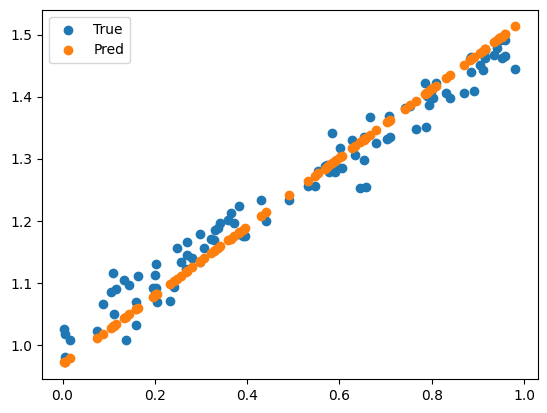

In [157]:
# Plot the result
fig, ax = plt.subplots()
ax.scatter(X, y, label='True')
ax.scatter(X, y_preds.detach().cpu(), label='Pred')
ax.legend();

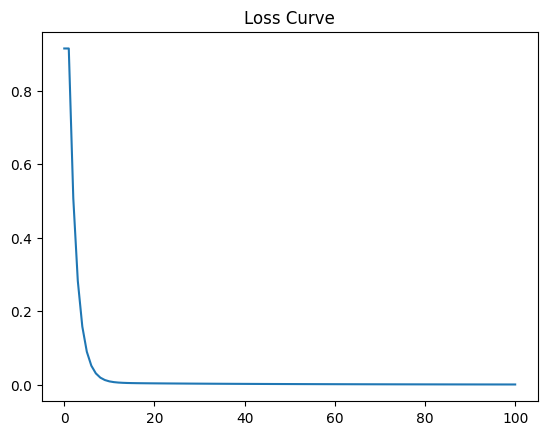

In [158]:
# Plotting the loss curve
result_loss = [r['loss'] for r in results]
plt.plot(result_loss)
plt.title('Loss Curve');

## Visualizing the Loss Surface



In [159]:
import numpy as np

# define a function to plot out Loss surface and path of gradient descent
def plot_path(results, w_true, b_true, X):

    # Split the ranges in 100 evenly space intervlas each
    w_range = np.linspace(w_true -1, w_true + 1, 101)
    b_range = np.linspace(b_true -1, b_true + 1, 101)

    # Use mesgrid to generates a grid of w and b for all combination
    bs, ws = np.meshgrid(b_range, w_range)

    # Make all predictions according to the generated grid of w and b
    all_predictions = np.apply_along_axis(
        func1d=lambda x: ws * x + bs,
        axis=1,
        arr=X.numpy().reshape(-1, 1),
    )

    # Calculate all errors (errors per data point) per points in grid
    all_labels = y.numpy().reshape(-1, 1, 1)
    all_errors = (all_predictions - all_labels)

    # Calculate losses (MSE) per points in grid
    all_losses = (all_errors ** 2).mean(axis=0)


    figure = plt.figure(figsize=(12, 6))

    # 1st plot - 3d surface plot with minimum point and starting point
    ax1 = figure.add_subplot(1, 2, 1, projection='3d')
    ax1.set_xlabel('b')
    ax1.set_ylabel('w')
    ax1.set_title('Loss Surface')
    ax1.plot_surface(bs, ws, all_losses, rstride=1, cstride=1, alpha=.5, cmap=plt.cm.jet, linewidth=0, antialiased=True)
    ax1.scatter(b_true, w_true, mse(model(X, torch.tensor([w_true, b_true])), y), c="k", label='Minimum')
    ax1.scatter(results[0]['b'], results[0]['w'], results[0]['loss'], c='r', label='Initial')
    for result in results:
        ax1.scatter(result['b'], result['w'], result['loss'], c='r')
    ax1.legend()

    # 2nd plot - contour
    ax2 = figure.add_subplot(1, 2, 2)
    ax2.set_xlabel('b')
    ax2.set_ylabel('w')
    ax2.set_title('Loss Contour')
    ax2.contour(bs[0, :], ws[:, 0], all_losses, cmap=plt.cm.jet)
    ax2.scatter(b_true, w_true, c='k', label='Minimum')
    ax2.scatter(results[0]['b'], results[0]['w'], c='r', label="Initial")
    for result in results:
        ax2.scatter(result['b'], result['w'], c='r')
    ax2.legend();

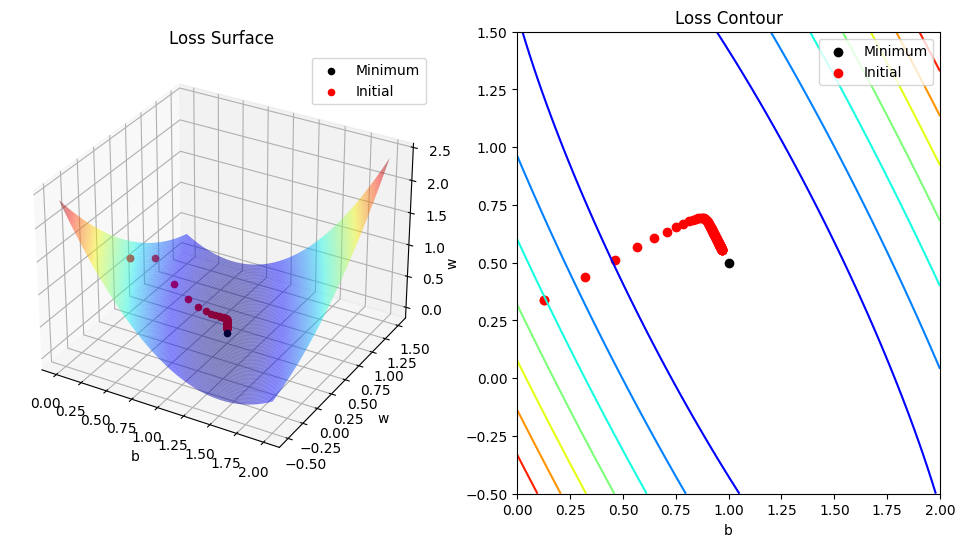

In [160]:
plot_path(results, w_true, b_true, X)

## Effect on Learning Rates

Learning Rate is the most important hyper-parameter. While gradient descent gives you direction of local/global minimum, a wrong learning rate can still completely ruin the model training.


***Low Learning Rate***

For Learning Rate that is too low, while it is safe(r) as expected that the training will arrive at the minimum point, it would take a lot of time. Below shows the results of low learning rate. As shown below, we use a learning rate of 0.01 instead of 0.1, while the path is the same, we cannot arrive at the minimum point within the set epochs

In [161]:
# Low learning Rate exercise

lr = 0.01
n_epochs = 100

# Set manual seed
torch.manual_seed(42)

# Step 1 - Initialize the weights
params = torch.randn(2, requires_grad=True, dtype=torch.float)

# append first result as initial random initiations
results_lowlr=[]
results_lowlr.append({'epoch': 0,
                'loss': mse(model(X, params), y).item(),
                'w': params.data[0].item(),
                'b': params.data[1].item()})

for epoch in range(n_epochs):
    # Step 2 - Make predictions using the model
    y_preds = model(X, params)
    # Step 3 - Compute the Loss
    loss = mse(y_preds, y)
    # Step 4 - Compute the Gradients
    loss.backward()
    # Step 5 - `step()` to Update the parameters and zero grad as loss is cumulative
    params.data -= lr * params.grad
    params.grad = None
    results_lowlr.append({'epoch': epoch+1,
                   'loss': loss.item(),
                   'w': params.data[0].item(),
                   'b': params.data[1].item()})

pd.DataFrame(results_lowlr)

,epoch,loss,w,b
0,0,0.914937,0.336690,0.128809
1,1,0.914937,0.346802,0.147914
2,2,0.868816,0.356645,0.166531
3,3,0.825036,0.366226,0.184675
4,4,0.783476,0.375553,0.202357
...,...,...,...,...
96,96,0.011530,0.679056,0.821404
97,97,0.011191,0.679612,0.823125
98,98,0.010868,0.680146,0.824805
99,99,0.010561,0.680659,0.826446


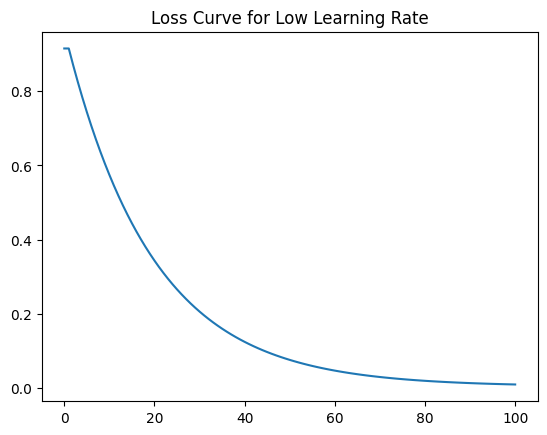

In [162]:
# Plotting the loss curve
plt.plot([r['loss'] for r in results_lowlr])
plt.title('Loss Curve for Low Learning Rate');

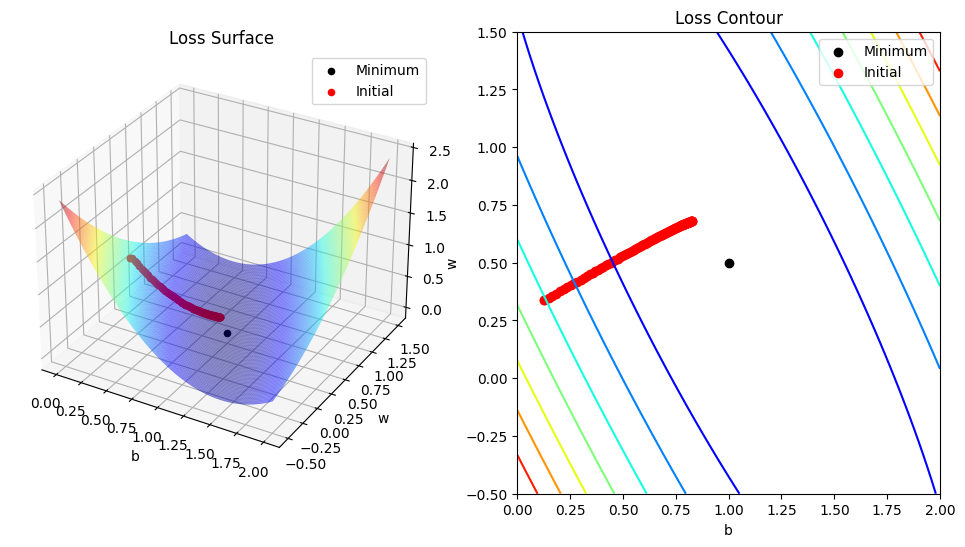

In [163]:
plot_path(results_lowlr, w_true, b_true, X)

***High Learning Rate***

While there is an incentive to try higher leraning rates, a learning rate that is too high may fail to arrive at minimum point. As shown below, with learning rate that is too high, we ended up on the other side of the curve that is not good. While in this case, we still ended up at the minimum but with weird shape of the Loss Surface, bouncing to the other side may lead to the algo wihtout ever approaching the minimum

In [164]:
# High learning Rate exercise
torch.manual_seed(42)
lr = 0.7
n_epochs = 100

# Step 1 - Initialize the weights
params = torch.randn(2, requires_grad=True, dtype=torch.float)

# append first result as initial random initiations
results_highlr=[]
results_highlr.append({'epoch': 0,
                'loss': mse(model(X, params), y).item(),
                'w': params.data[0].item(),
                'b': params.data[1].item()})

for epoch in range(n_epochs):
    # Step 2 - Make predictions using the model
    y_preds = model(X, params)
    # Step 3 - Compute the Loss
    loss = mse(y_preds, y)
    # Step 4 - Compute the Gradients
    loss.backward()
    # Step 5 - `step()` to Update the parameters and zero grad as loss is cumulative
    params.data -= lr * params.grad
    params.grad = None
    results_highlr.append({'epoch': epoch+1,
                   'loss': loss.item(),
                   'w': params.data[0].item(),
                   'b': params.data[1].item()})

pd.DataFrame(results_highlr)

,epoch,loss,w,b
0,0,0.914937,0.336690,0.128809
1,1,0.914937,1.044477,1.466100
2,2,0.585651,0.437752,0.420047
3,3,0.375145,0.885418,1.276621
4,4,0.240537,0.493906,0.610705
...,...,...,...,...
96,96,0.000597,0.486168,1.006911
97,97,0.000597,0.486166,1.006912
98,98,0.000597,0.486164,1.006913
99,99,0.000597,0.486163,1.006914


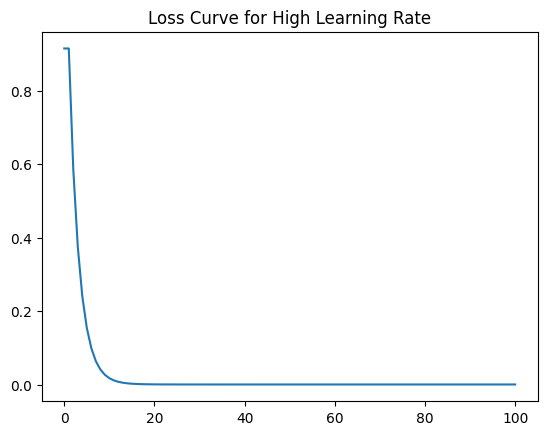

In [165]:
# Plotting the loss curve
plt.plot([r['loss'] for r in results_highlr])
plt.title('Loss Curve for High Learning Rate');

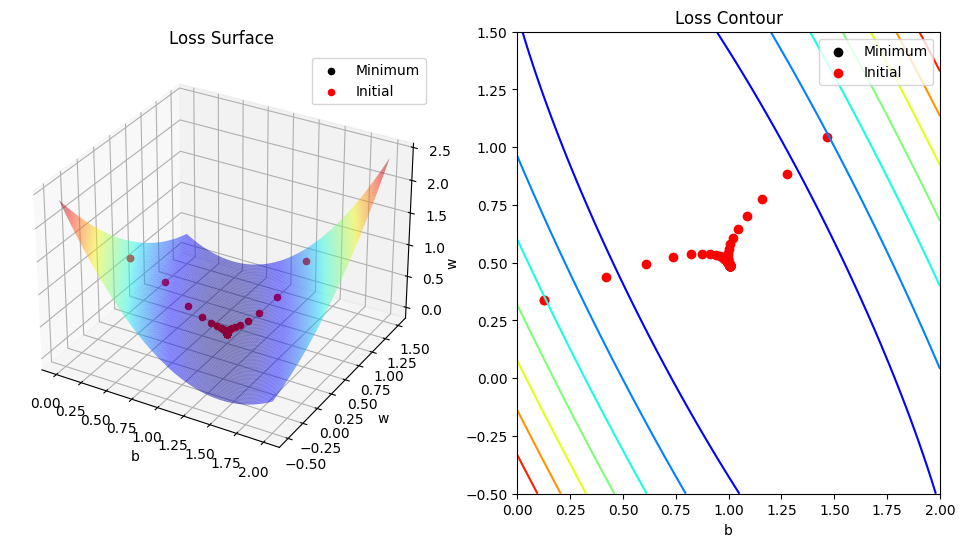

In [166]:
plot_path(results_highlr, w_true, b_true, X)

## Zero Mean and Unit Standard Deviation

Scaling the feature values such that its standard deviation equals one and Centering the feature at zero mean is one of the most important pre-processing steps not just for **gradient descent**, but also for principal **component analysis (PCA)**. The goal is to have all numerical features in a similar scale.

To standardize the features, we compute the mean and stardard deviation with the scaled features equals to below:

$$
scaled\ x_i = \frac{x - \overline{X}}{\sigma(X)}
$$

where,
 $$
\overline{X} = \frac{1}{N}\sum_{i=1}^{N}x_i
 $$

 $$
\sigma(X) = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(x_i-\overline{X})^2}
 $$

In [167]:
scaled_X = (X - X.mean())/X.std()

Note that w_true and b_true also need to be scaled for the scaled_X

$$
y = wx + b
$$

$$
y = w_s x_s + b_s
$$

$$
y = w_s \frac{x-\overline{X}}{\sigma(X)} + b_s
$$

$$
y = \frac{w_s}{\sigma(X)} x + (b_s - \frac{w_s\overline{X} }{\sigma(X)})
$$

$$
w_s = \sigma(X)w
$$

$$
b_s = b + \frac{w_s \overline{X}}{\sigma(X)}
$$

In [168]:
# Note that w_true and b_true also need to be scaled
w_true_scaled = w_true * X.std()
b_true_scaled = b_true + (w_true_scaled * X.mean()/ X.std())

print(w_true_scaled, b_true_scaled)

tensor(0.1473) tensor(1.2579)


We do not need to regenerate the data, label_y is left unchanged

In [170]:
# Using a scaled X
torch.manual_seed(42)
lr = 0.1
n_epochs = 100

# Step 1 - Initialize the weights
params = torch.randn(2, requires_grad=True, dtype=torch.float)

# append first result as initial random initiations
results_scaled=[]
results_scaled.append({'epoch': 0,
                'loss': mse(model(X, params), y).item(),
                'w': params.data[0].item(),
                'b': params.data[1].item()})

for epoch in range(n_epochs):
    # Step 2 - Make predictions using the model
    y_preds = model(scaled_X, params)
    # Step 3 - Compute the Loss
    loss = mse(y_preds, y)
    # Step 4 - Compute the Gradients
    loss.backward()
    # Step 5 - `step()` to Update the parameters and zero grad as loss is cumulative
    params.data -= lr * params.grad
    params.grad = None
    results_scaled.append({'epoch': epoch+1,
                           'loss': loss.item(),
                           'w': params.data[0].item(),
                           'b': params.data[1].item()})

pd.DataFrame(results_scaled)

,epoch,loss,w,b
0,0,0.914937,0.336690,0.128809
1,1,1.312038,0.298378,0.354586
2,2,0.840038,0.267652,0.535207
3,3,0.537915,0.243010,0.679704
4,4,0.344530,0.223247,0.795301
...,...,...,...,...
96,96,0.000597,0.143196,1.257691
97,97,0.000597,0.143196,1.257691
98,98,0.000597,0.143196,1.257691
99,99,0.000597,0.143196,1.257691


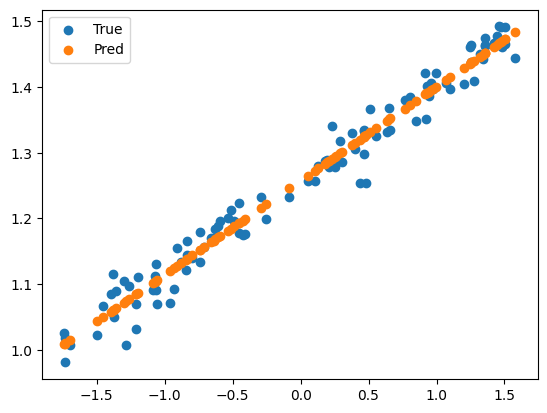

In [171]:
# Plot the result
fig, ax = plt.subplots()
ax.scatter(scaled_X, y, label='True')
ax.scatter(scaled_X, model(scaled_X, params).detach().numpy(), label='Pred')
ax.legend();

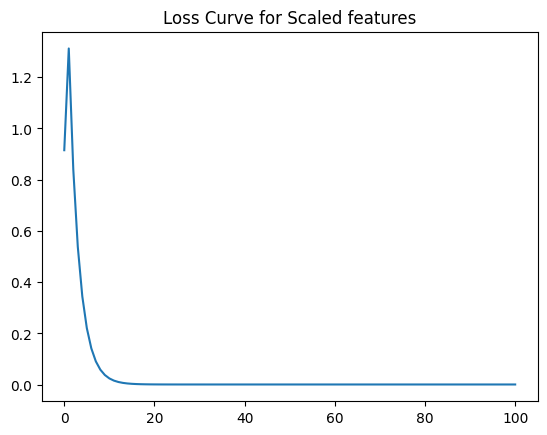

In [172]:
# Plotting the loss curve
plt.plot([r['loss'] for r in results_scaled])
plt.title('Loss Curve for Scaled features');

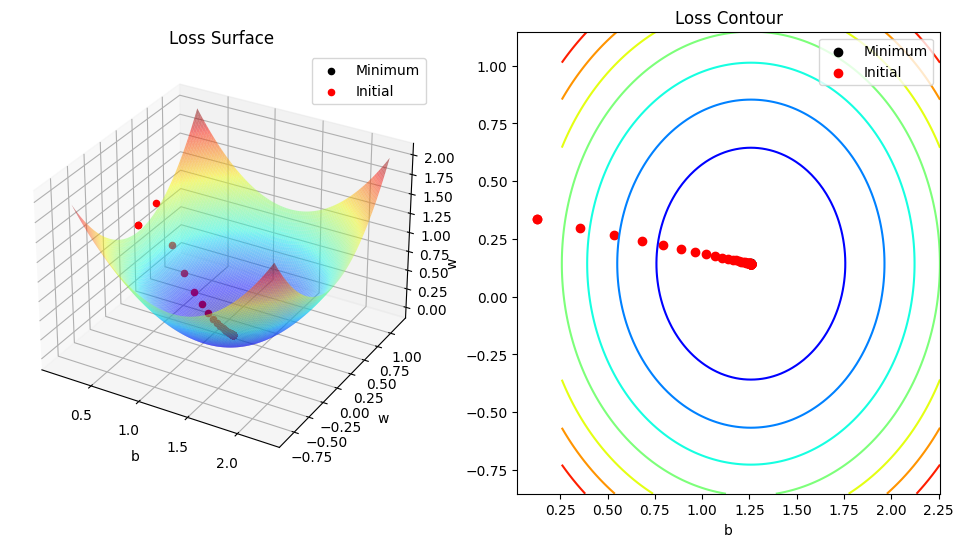

In [173]:
plot_path(results_scaled, w_true_scaled, b_true_scaled, scaled_X)

One of the reason why standardization helps with gardient descent learning is that it is easier to find a learning rate that works well for all weights (and the bias). If the features are on vastly different scales, a learning rate that works well for updating one weight might be too large or too small to update the other weight equally well. Overall using standardized features can stablize the training such that the optimizer has to go through fewer steps to find a good or optimal solution. As shown above, the contour of loss surface is now more rounded with similar scale for both features b and w.

## Stochastic gradient descent for Large-scale machine learning

Note that what we have done above is full batch gradient descent as all data are used in every step in the descent calculation. This works for small dataset but will struggle with large dataset that is common for machine learning applications. Running full batch gradient descent can be compututationally too costly in such scenarios. A popular alternative to the batch gradient descent algorithm is **stochastic gradient descent (SGD)**. Instead of updating the weights based on teh sum of the accumulated erros over all training sample, we update the parameters incrementally for each training batch which is a subset of the full samples.

Although SGD can be considered as an approximation of gradient descent, it typically reaches convergence much faster because of the more frequent weight updates Since each gradient is caluclated based on a single training batch, the error surface is noisier than in gradient descent, which can also have the advantage that SGD can escape shallow local minima more readily if we are working with nonlinear loss functions. To obtain satisfying results via SGD, it is important to present training data in a random order; also, we want to shuffle the training dataset for every epoch to prevent cycles.

Another advantage of SGD is that we can use it for **online learning**. In online learning, our model is trained ont eh fly as new training data arrives. This is especailly useful if we are accumulating large amounts of data where system can immediately adapt to changes and the training data can be discarded after updating the model if storage space is an issue,